In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
review_data=pd.read_csv('https://raw.githubusercontent.com/kiryouri/disneyland_branch_project/main/DisneylandReviews_modified.csv',encoding='latin-1', index_col=0)

In [3]:
review_data.columns = map(str.lower, review_data.columns) #в lowercase для удобства
review_data['branch']=review_data.branch.str.replace('Disneyland_','')
review_data.isnull().sum()  #na check

review_id            0
rating               0
year_month           0
reviewer_location    0
branch               0
dtype: int64

In [4]:
review_data.review_id.value_counts() #проверяю id на дубликаты

121586148    2
129231609    2
164830205    2
129207323    2
166787635    2
            ..
127111751    1
359629381    1
609401410    1
184721985    1
322889295    1
Name: review_id, Length: 42636, dtype: int64

In [5]:
review_data=review_data.drop_duplicates()

In [6]:
review_data=review_data.drop(['reviewer_location'], axis = 1)
review_data

,review_id,rating,year_month,branch
0,670772142,4,2019-4,HongKong
1,670682799,4,2019-5,HongKong
2,670623270,4,2019-4,HongKong
3,670607911,4,2019-4,HongKong
4,670607296,4,2019-4,HongKong
...,...,...,...,...
42651,1765031,5,missing,Paris
42652,1659553,5,missing,Paris
42653,1645894,5,missing,Paris
42654,1618637,4,missing,Paris


In [7]:
review_data.branch.unique() #получаю список уникальных подразделений

In [8]:
#для дальнейшей оценки логичным будет удалить отзывы без даты
review_data.year_month
review_data_without_missings = review_data.loc[review_data['year_month'] != 'missing'] #фильтрую чтобы не было неконвертабельных значений

In [9]:
review_data_without_missings['year_month']=pd.to_datetime(review_data_without_missings['year_month'], format='%Y-%m') #для дальнейших действий форматирую в datetime
review_data_without_missings.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40023 entries, 0 to 42117
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   review_id   40023 non-null  int64         
 1   rating      40023 non-null  int64         
 2   year_month  40023 non-null  datetime64[ns]
 3   branch      40023 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.4+ MB


In [10]:
#формирую новые колонки
review_data_without_missings['season']=review_data_without_missings.year_month.dt.month%12 // 3 + 1 #формирую сезоны из месяцев
review_data_without_missings['month']=review_data_without_missings.year_month.dt.month
review_data_without_missings['year']=review_data_without_missings.year_month.dt.year

In [11]:
review_data_without_missings.season=review_data_without_missings.season.replace({1:'winter', 2:'spring', 3:'summer', 4:'fall'}) #цифры в названия

In [12]:
rating_by_season=review_data_without_missings.groupby('season', as_index=False).rating.mean() #средние арифметические по сезонам

In [13]:
rating_by_season

,season,rating
0,fall,4.303917
1,spring,4.216547
2,summer,4.173067
3,winter,4.243103


In [14]:
rating_by_season_and_branch=review_data_without_missings.groupby(['season','branch'], as_index=False).rating.mean() #средние арифметические по сезонам и подразделениям
rating_by_season_and_branch

,season,branch,rating
0,fall,California,4.451174
1,fall,HongKong,4.246187
2,fall,Paris,4.113274
3,spring,California,4.378306
4,spring,HongKong,4.263003
5,spring,Paris,3.951281
6,summer,California,4.444896
7,summer,HongKong,4.106557
8,summer,Paris,3.872032
9,winter,California,4.370212


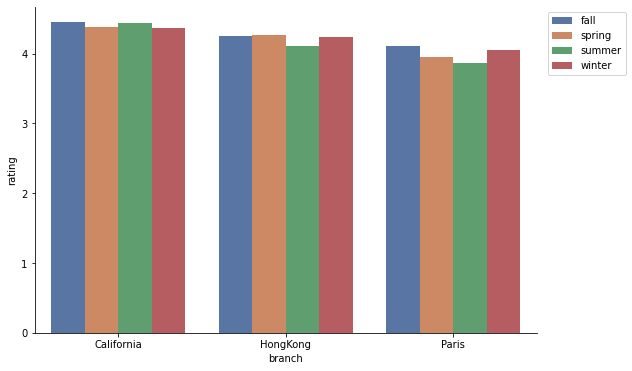

In [15]:
#строю графики по каждому подразделению-сезону
plt.figure(figsize=(9,6))
sns.barplot(x='branch', y='rating', hue='season', data=rating_by_season_and_branch,palette='deep')
plt.legend(loc='upper center', bbox_to_anchor=(1.10, 1.0), ncol=1) #перемещаю hue legend чтобы не перекрывала график
sns.despine()
#наибольшая разница в Париже осень vs лето, продолжу с этими данными

In [16]:
rating_by_season_and_branch.query('branch=="Paris"').reset_index(drop=True)

,season,branch,rating
0,fall,Paris,4.113274
1,spring,Paris,3.951281
2,summer,Paris,3.872032
3,winter,Paris,4.050100


In [17]:
paris_rating_by_season=review_data_without_missings.query('branch=="Paris"').reset_index(drop=True).groupby(['season','rating']).agg({'review_id':'count'}).rename(columns={'review_id': 'rating_count'}) 
#фильтр по Парижу, группировка, подсчет количества оценок

In [18]:
paris_rating_by_season['percentage'] = paris_rating_by_season.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)*100) #создаю колонку с процентами

In [19]:
paris_rating_by_season=paris_rating_by_season.reset_index()

In [20]:
data_fall=paris_rating_by_season.query('season=="fall"')
data_summer=paris_rating_by_season.query('season=="summer"') #делаю отдельные df для каждого из рассматриваемых сезонов

In [21]:
data_fall

,season,rating,rating_count,percentage
0,fall,1,131,5.0
1,fall,2,172,6.0
2,fall,3,389,14.0
3,fall,4,687,24.0
4,fall,5,1446,51.0


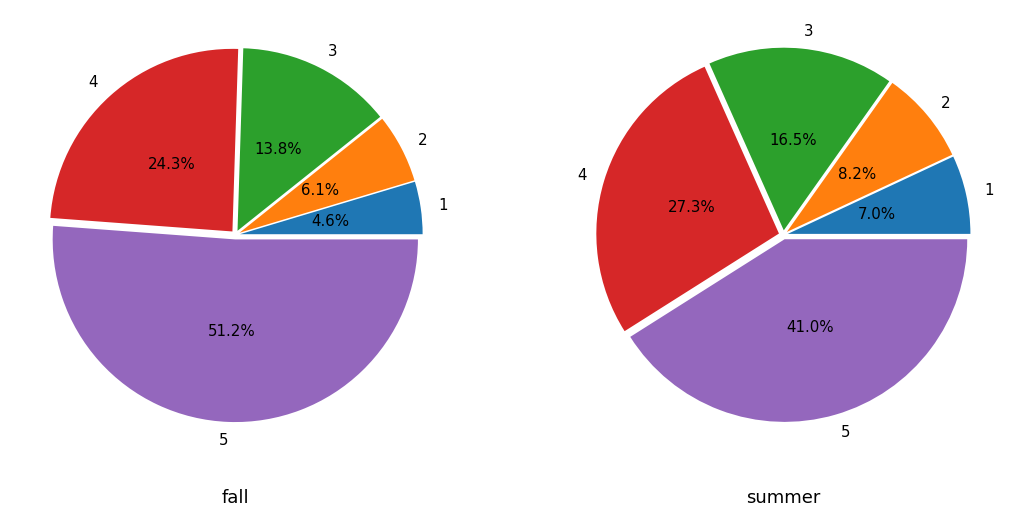

In [22]:
pie, (ax1, ax2) = plt.subplots(1, 2, figsize=[18,12])
#рисую оба пайчарта в сабплотах
plt.rcParams['font.size'] = 15.0
ax1.set_title('fall', loc='center', y=-0.1)
ax2.set_title('summer', loc='center', y=-0.1)
ax1.pie(x=data_fall.rating_count, autopct="%.1f%%", explode=[0.025]*5, labels=list(data_fall.rating), pctdistance=0.5) 
ax2.pie(x=data_summer.rating_count, autopct="%.1f%%", explode=[0.025]*5, labels=list(data_summer.rating), pctdistance=0.5) 
#autopct - разрядность, pctdistance - расположение процентов

plt.show()

In [23]:
data_fall_summer=pd.concat([data_fall,data_summer]).reset_index(drop=True) #конкатенирую датафреймы со сбросом индекса для дальнейших действий

In [24]:
data_fall_summer

,season,rating,rating_count,percentage
0,fall,1,131,5.0
1,fall,2,172,6.0
2,fall,3,389,14.0
3,fall,4,687,24.0
4,fall,5,1446,51.0
5,summer,1,293,7.0
6,summer,2,347,8.0
7,summer,3,694,16.0
8,summer,4,1150,27.0
9,summer,5,1728,41.0


<AxesSubplot:xlabel='season'>

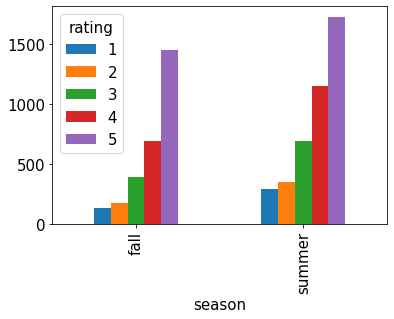

In [25]:
pivoted_df=data_fall_summer.pivot(index='season',columns='rating',values='rating_count') #делаю сводную таблицу
pivoted_df.plot(kind='bar')
#H0 - сезон (осень/лето) не влияет на оценку, H1 - влияет

In [26]:
#Строю таблицу сопряженности
contingency_table = pd.crosstab(
    paris_rating_by_season['season'], 
    paris_rating_by_season['rating'],
    paris_rating_by_season['rating_count'], #index, columns, values
    aggfunc='sum',
    margins = True
)
contingency_table 

rating,1,2,3,4,5,All
season,,,,,,
fall,131,172,389,687,1446,2825
spring,190,239,503,832,1397,3161
summer,293,347,694,1150,1728,4212
winter,122,179,347,651,1196,2495
All,736,937,1933,3320,5767,12693


In [27]:
r_obs = np.array([contingency_table.iloc[0][0:6].values,
                  contingency_table.iloc[2][0:6].values]) #observed values
r_obs

array([[ 131,  172,  389,  687, 1446, 2825],
       [ 293,  347,  694, 1150, 1728, 4212]], dtype=int64)

In [28]:
contingency_table.iloc[0][0:6].values #values для осени
contingency_table.iloc[2][0:6].values #values для лета

array([ 293,  347,  694, 1150, 1728, 4212], dtype=int64)

In [29]:
from scipy import stats
stats.chi2_contingency(r_obs)[0:3] #chi2, p, dof

(78.20874795836986, 1.9880990320811147e-15, 5)

In [30]:
#Можно отклонить H0 об отсутствии влияния сезона, рискуя ошибиться с околонулевой вероятностью